# Importing Data and Libraries
### Library Imports

In [42]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from sqlalchemy import create_engine
import psycopg2
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFECV
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import SelectFromModel
from sklearn.cluster import KMeans
from sklearn.model_selection import train_test_split

sns.set_palette('coolwarm')

### Creating the Initial Model Dataset

After consolidating the data into what I am calling 'silver' level tables in the Postgre database, we can export them all to csv's in PGAdmin and bring them into pandas dataframes. From here the datasets will be joined to the instructor dataset, since this is the primary dataset I want as the root. I will also be performing a search for duplicate columns, as an extra precaution.

In [43]:
schools = pd.read_csv("Datasets/schools_silver.csv")
instructors = pd.read_csv("Datasets/Instructors_silver.csv")
demographics = pd.read_csv("Datasets/Demographics_silver.csv")
scores = pd.read_csv("Datasets/scores_silver.csv")

In [44]:
employer = instructors.join(schools,rsuffix='_other',lsuffix='_main').join(demographics,rsuffix='_instructor',lsuffix='_other').join(scores,rsuffix='_instructor',lsuffix='_other')
employer.drop(['institution_other','institution_instructor'],axis=1,inplace=True)
employer.to_csv('Datasets/College_Employers.csv')

C:\Users\pants\anaconda3\lib\site-packages\pandas\core\frame.py:9130: FutureWarning: Passing 'suffixes' which cause duplicate columns {'institution_other'} in the result is deprecated and will raise a MergeError in a future version.
  return merge(


In [45]:
employer['row_num'] = employer.groupby(['institution_main']).cumcount()+1
employer = employer[employer['row_num']==1]
employer.drop('row_num',axis=1,inplace=True)

# EDA

### Staffing at Institutions of Different Sizes

Looking at the plot below it can be seen that institutions of similar sizes have similar staffing situations, looking at professors specifically, instsize category of 5 seems to have some more variance in amount of professors staffed.

Text(0.5, 1.0, 'Staffing at Post-Secondary Institutions of Different Sizes')

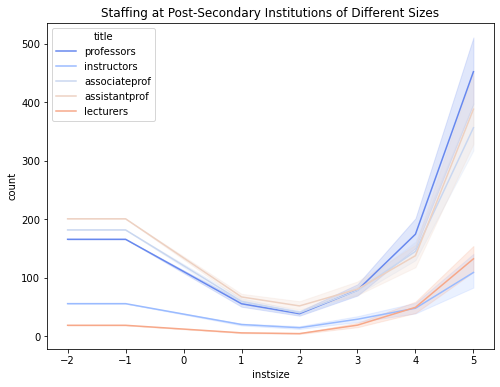

In [46]:
plt.figure
sizeplot = employer[['instsize','professors','instructors','associateprof','assistantprof','lecturers']]
sizeplot_melt = sizeplot.melt(id_vars='instsize',value_vars=['professors','instructors','associateprof','assistantprof','lecturers'],value_name='count',var_name='title')
sns.lineplot(data=sizeplot_melt, x='instsize',y='count',hue='title')
plt.title('Staffing at Post-Secondary Institutions of Different Sizes')

### Staffing at Institutions in Different States

Here I am looking for any significant similarities among all of the states. In general Assistant Professor seems to be the most hired position.

Text(0.5, 1.0, 'Staffing at Post-Secondary Institutions of Different States')

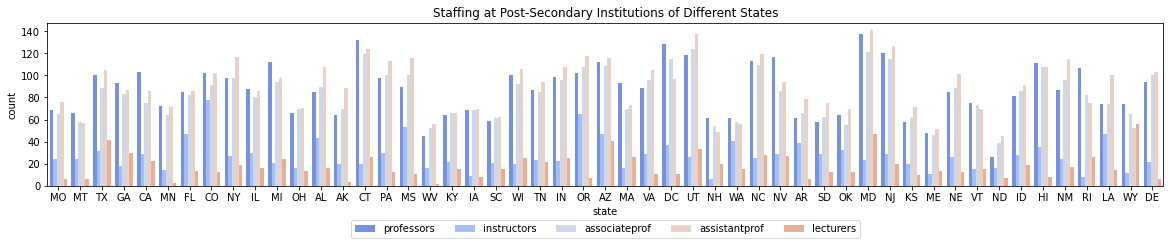

In [47]:
barplot = employer[['state','professors','instructors','associateprof','assistantprof','lecturers']]
barplot_melt = barplot.melt(id_vars='state',value_vars=['professors','instructors','associateprof','assistantprof','lecturers'],value_name='count',var_name='title')
plt.rcParams["figure.figsize"] = (20,3)
sns.barplot(data=barplot_melt, x='state',y='count',hue='title',ci=None)
plt.legend(loc='lower center',bbox_to_anchor=(.5, -0.35), ncol=5)
plt.title("Staffing at Post-Secondary Institutions of Different States")

### Types of Institutions

Here I want to find out how much of our data set is covered by these flags, the public flag does not gain any confusion as there is only 1 non-flag, there are 86 hbcu's in this set, and 17 tribal schools

In [48]:
employer[employer['publicflag']==0].head()

,institution_main,professors,associateprof,assistantprof,instructors,lecturers,state,instlevel,instcontrol,hbcuflag,...,sat25thperreading,sat75thperreading,sat25thpermath,sat75thpermath,act25thpercomp,act75thpercomp,act25thpereng,act75thpereng,act25thpermath,act75thpermath
95,Antioch University-Midwest,166,182,201,56,19,OH,1,2,2,...,455,625,502,661,22,22,23,27,22,24


In [71]:
hbcu = employer[employer['hbcuflag']==1]
hbcu['institution_main'].shape

(86,)

In [50]:
employer[employer['tribalflag']==1].head()

,institution_main,professors,associateprof,assistantprof,instructors,lecturers,state,instlevel,instcontrol,hbcuflag,...,sat25thperreading,sat75thperreading,sat25thpermath,sat75thpermath,act25thpercomp,act75thpercomp,act25thpereng,act75thpereng,act25thpermath,act75thpermath
1,Aaniiih Nakoda College,0,0,0,14,0,MT,1,1,2,...,455,625,502,661,22,22,23,27,22,24
191,Bay Mills Community College,0,0,0,0,0,MI,1,1,2,...,455,625,502,661,22,22,23,27,22,24
497,College of Menominee Nation,0,0,0,18,0,WI,1,2,2,...,455,625,502,661,22,22,23,27,22,24
642,Dine College,13,14,12,24,0,AZ,1,1,2,...,455,625,502,661,22,22,23,27,22,24
888,Haskell Indian Nations University,0,0,0,0,0,KS,1,1,2,...,490,590,490,580,17,27,16,25,17,26


### HBCU Institutions

HBCU Institutions have become a popular destination for athletes as of lately, it may be useful to see if this past school year saw these schools ranking higher in some statistics, the goal is to find the HBCU institutions for the plot will zoom in to the large cluster

(0.0, 300.0)

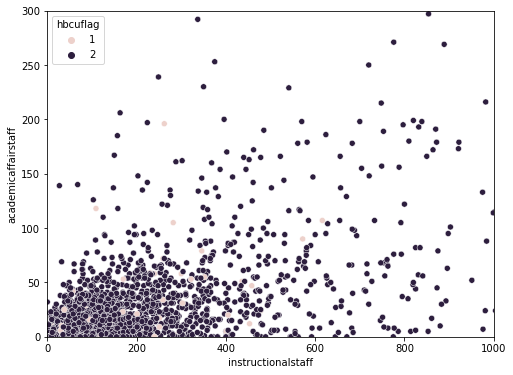

In [51]:
rateplot = employer[['instructionalstaff','academicaffairstaff','hbcuflag']]
plt.rcParams['figure.figsize'] = (8,6)
sns.scatterplot(data=rateplot, x='instructionalstaff', y='academicaffairstaff',hue='hbcuflag')
plt.xlim(0,1000)
plt.ylim(0,300)


It is worth it to look back at these schools to see what cluster they will end up in.

In [52]:
HBCU_Affairs = employer.loc[(employer['academicaffairstaff']>100) & (employer['hbcuflag']==1)]
HBCU_Affairs.head()

,institution_main,professors,associateprof,assistantprof,instructors,lecturers,state,instlevel,instcontrol,hbcuflag,...,sat25thperreading,sat75thperreading,sat25thpermath,sat75thpermath,act25thpercomp,act75thpercomp,act25thpereng,act75thpereng,act25thpermath,act75thpermath
757,Florida Agricultural and Mechanical University,150,166,137,80,0,FL,1,1,1,...,530,670,510,668,21,28,20,28,20,27
780,Fort Valley State University,26,31,28,3,7,GA,1,1,1,...,455,625,502,661,22,22,23,27,22,24
1325,Morehouse School of Medicine,74,64,78,20,0,GA,1,2,1,...,455,625,502,661,22,22,23,27,22,24
1408,Norfolk State University,78,59,82,23,0,VA,1,1,1,...,455,625,502,661,22,22,23,27,22,24


# Feature Selection

### Normalizing the data

Normalizing data is a typical practice in machine learning which consists of transforming numeric columns to a standard scale. In machine learning, some feature values differ from others multiple times. The features with higher values will dominate the learning process. I want to balance my data set, this should help especially since the test score columns could dominate the feature selection.

In [53]:
numcols = list(employer.select_dtypes(['float64','int64']))
norm_employer = employer.copy()
for column in numcols:
    norm_employer[column] = norm_employer[column] / norm_employer[column].abs().max()

In [54]:
import category_encoders as ce

encoder= ce.OrdinalEncoder(cols=['predominantdemo_bachelors','predominantdemo_masters','predominantdemo_phd','inststatus'],return_df=True,
                           mapping=[{'col':'predominantdemo_bachelors',
'mapping':{'White':0,'Hispanic':1,'Black':2,'Asian':3,'NativeAmerican':4,'PacificIslander':5, 'UnknownEthnicity':6}},{'col':'predominantdemo_masters',
'mapping':{'White':0,'Hispanic':1,'Black':2,'Asian':3,'NativeAmerican':4,'PacificIslander':5, 'UnknownEthnicity':6}},{'col':'predominantdemo_phd',
'mapping':{'White':0,'Hispanic':1,'Black':2,'Asian':3,'NativeAmerican':4,'PacificIslander':5, 'UnknownEthnicity':6}},{'col':'inststatus','mapping' :{'A':0,'N':1,'G':2,'M':3,'D':4,'R':5,'C':5}}])

norm_employer = encoder.fit_transform(norm_employer)

norm_employer['inststatus'] = norm_employer['inststatus'].astype('int64')
norm_employer['predominantdemo_bachelors'] = norm_employer['predominantdemo_bachelors'].astype('int64')
norm_employer['predominantdemo_masters'] = norm_employer['predominantdemo_masters'].astype('int64')
norm_employer['predominantdemo_phd'] = norm_employer['predominantdemo_phd'].astype('int64')

norm_employer.fillna(method='bfill',inplace=True)

In [55]:
features = norm_employer.loc[:,(norm_employer.columns != 'institution_main') & (norm_employer.columns != 'state') & (norm_employer.columns != 'professors')]
target = norm_employer['professors']
features['confusion_var'] = random.randint(0,1000)
X_train,X_test,y_train,y_test = train_test_split(features,target,test_size=0.3,random_state=42)

C:\Users\pants\AppData\Local\Temp/ipykernel_10484/1675149960.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features['confusion_var'] = random.randint(0,1000)


In [56]:
rf = RandomForestRegressor(random_state=0)
rf.fit(X_train,y_train)

f_i = list(zip(features,rf.feature_importances_))

f_i.sort(key = lambda x : x[1])
feature_dict = {x[0]:x[1] for x in f_i}
score_list = []
feature_list = ['professors']

for key in feature_dict:
    if feature_dict[key] > 0:
        score_list.append(feature_dict[key])

for key in feature_dict:
    for score in score_list:
        if key != 'confusion_var':
            feature_list.append(key)
            break
        else:
            break

feature_set = norm_employer[feature_list].select_dtypes(exclude='object')
feature_set.fillna(method='bfill',inplace=True)



# Elbow Method

C:\Users\pants\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:881: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=11.
  warnings.warn(


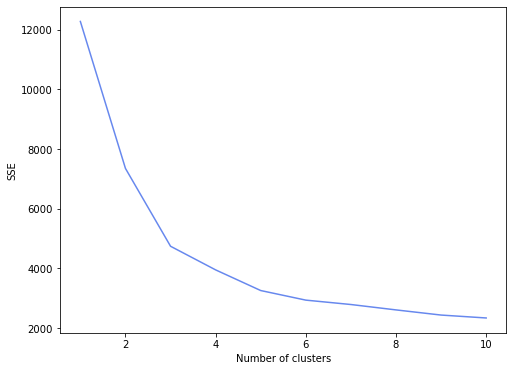

In [72]:
wcss = [] 
for i in range(1, 11): 
    kmeans = KMeans(n_clusters = i, random_state = 0)
    kmeans.fit(feature_set) 
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.xlabel('Number of clusters')
plt.ylabel('SSE') 
plt.show()

# K-Means Model

In [67]:
kmeans = KMeans(n_clusters = 5, random_state = 0)
y_kmeans = kmeans.fit_predict(feature_set)


In [ ]:
feature_set['cluster'] = pd.Series(y_kmeans)
feature_set['institution'] = employer['institution_main']

feature_set['cluster'].value_counts()

0.0    975
2.0    917
1.0    563
4.0    121
3.0     58
Name: cluster, dtype: int64

In [ ]:
hbcu_cluster = feature_set[feature_set['hbcuflag'] == 0.5]
no_hbcu = feature_set[feature_set['hbcuflag'] == 1.0]
hbcu_cluster['cluster'].value_counts()

2.0    28
0.0    28
1.0    24
4.0     4
3.0     2
Name: cluster, dtype: int64

Text(0.5, 1.0, 'HBCU Institutions by Cluster')

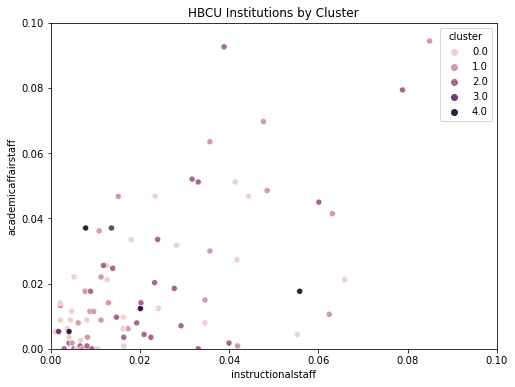

In [ ]:
rateplot = hbcu_cluster[['instructionalstaff','academicaffairstaff','cluster']]
plt.rcParams['figure.figsize'] = (8,6)
sns.scatterplot(data=rateplot, x='instructionalstaff', y='academicaffairstaff',hue='cluster')
plt.xlim(0,.1)
plt.ylim(0,.1)
plt.title("HBCU Institutions by Cluster")

Text(0.5, 1.0, 'Non-HBCU Institutions by Cluster')

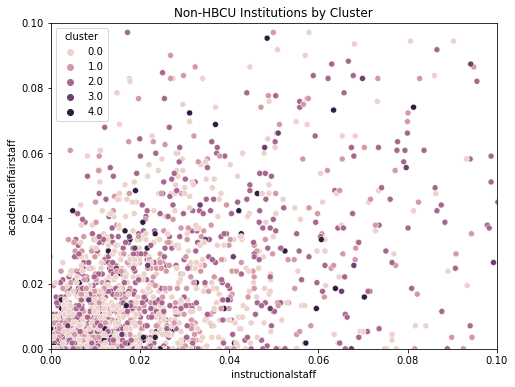

In [66]:
rateplot = no_hbcu[['instructionalstaff','academicaffairstaff','cluster']]
plt.rcParams['figure.figsize'] = (8,6)
sns.scatterplot(data=rateplot, x='instructionalstaff', y='academicaffairstaff',hue='cluster')
plt.scatter(centers[:,0], centers[:,1], marker="x", color='r')
plt.xlim(0,0.1)
plt.ylim(0,0.1)
plt.title('Non-HBCU Institutions by Cluster')

Text(0.5, 1.0, 'Non-HBCU Institutions by Cluster')

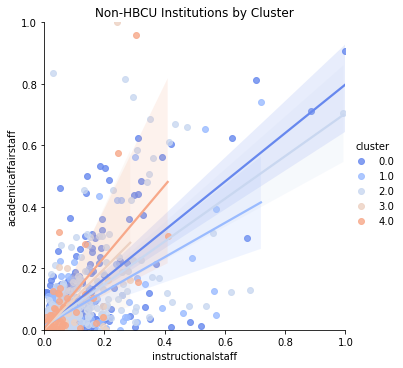

In [ ]:
rateplot = no_hbcu[['instructionalstaff','academicaffairstaff','cluster']]
plt.rcParams['figure.figsize'] = (8,6)
sns.lmplot(data=rateplot, x='instructionalstaff', y='academicaffairstaff',hue='cluster')
plt.xlim(0,1)
plt.ylim(0,1)
plt.title('Non-HBCU Institutions by Cluster')

Text(0.5, 1.0, 'Professors vs. Assistant Professors by Cluster')

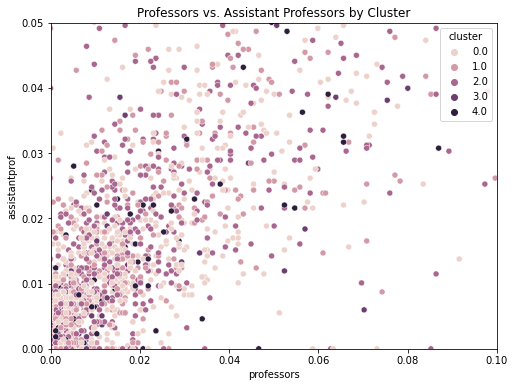

In [ ]:
rateplot = feature_set[['assistantprof','cluster','professors']]
sns.scatterplot(data=rateplot, y='assistantprof', x='professors',hue='cluster')
plt.xlim(0,.1)
plt.ylim(0,.05)
plt.title('Professors vs. Assistant Professors by Cluster')

In [ ]:
feature_set['state']=employer['state']

state_cluster = feature_set[['state','cluster']]
state_cluster_one_hot = pd.get_dummies(state_cluster.cluster)
state_cluster_one_hot['state'] = state_cluster['state']
state_pivot = state_cluster_one_hot.pivot_table(index='state', aggfunc='sum')
state_pivot

,0.0,1.0,2.0,3.0,4.0
state,,,,,
AK,1,0,4,0,1
AL,10,8,15,0,3
AR,3,7,17,0,0
AZ,12,9,13,0,2
CA,110,50,94,2,11
CO,21,10,11,0,3
CT,8,8,14,0,0
DC,9,1,7,0,0
DE,0,2,3,1,1
